To obtain a clean sample we need to choose a requirement on the signal score. This is achieved by looking at signal and background yields in data as a function of the BDT score. The yields are determined from a fit to the mass distribution, where a polynominal is used to model background, and a Gaussian for signal. 

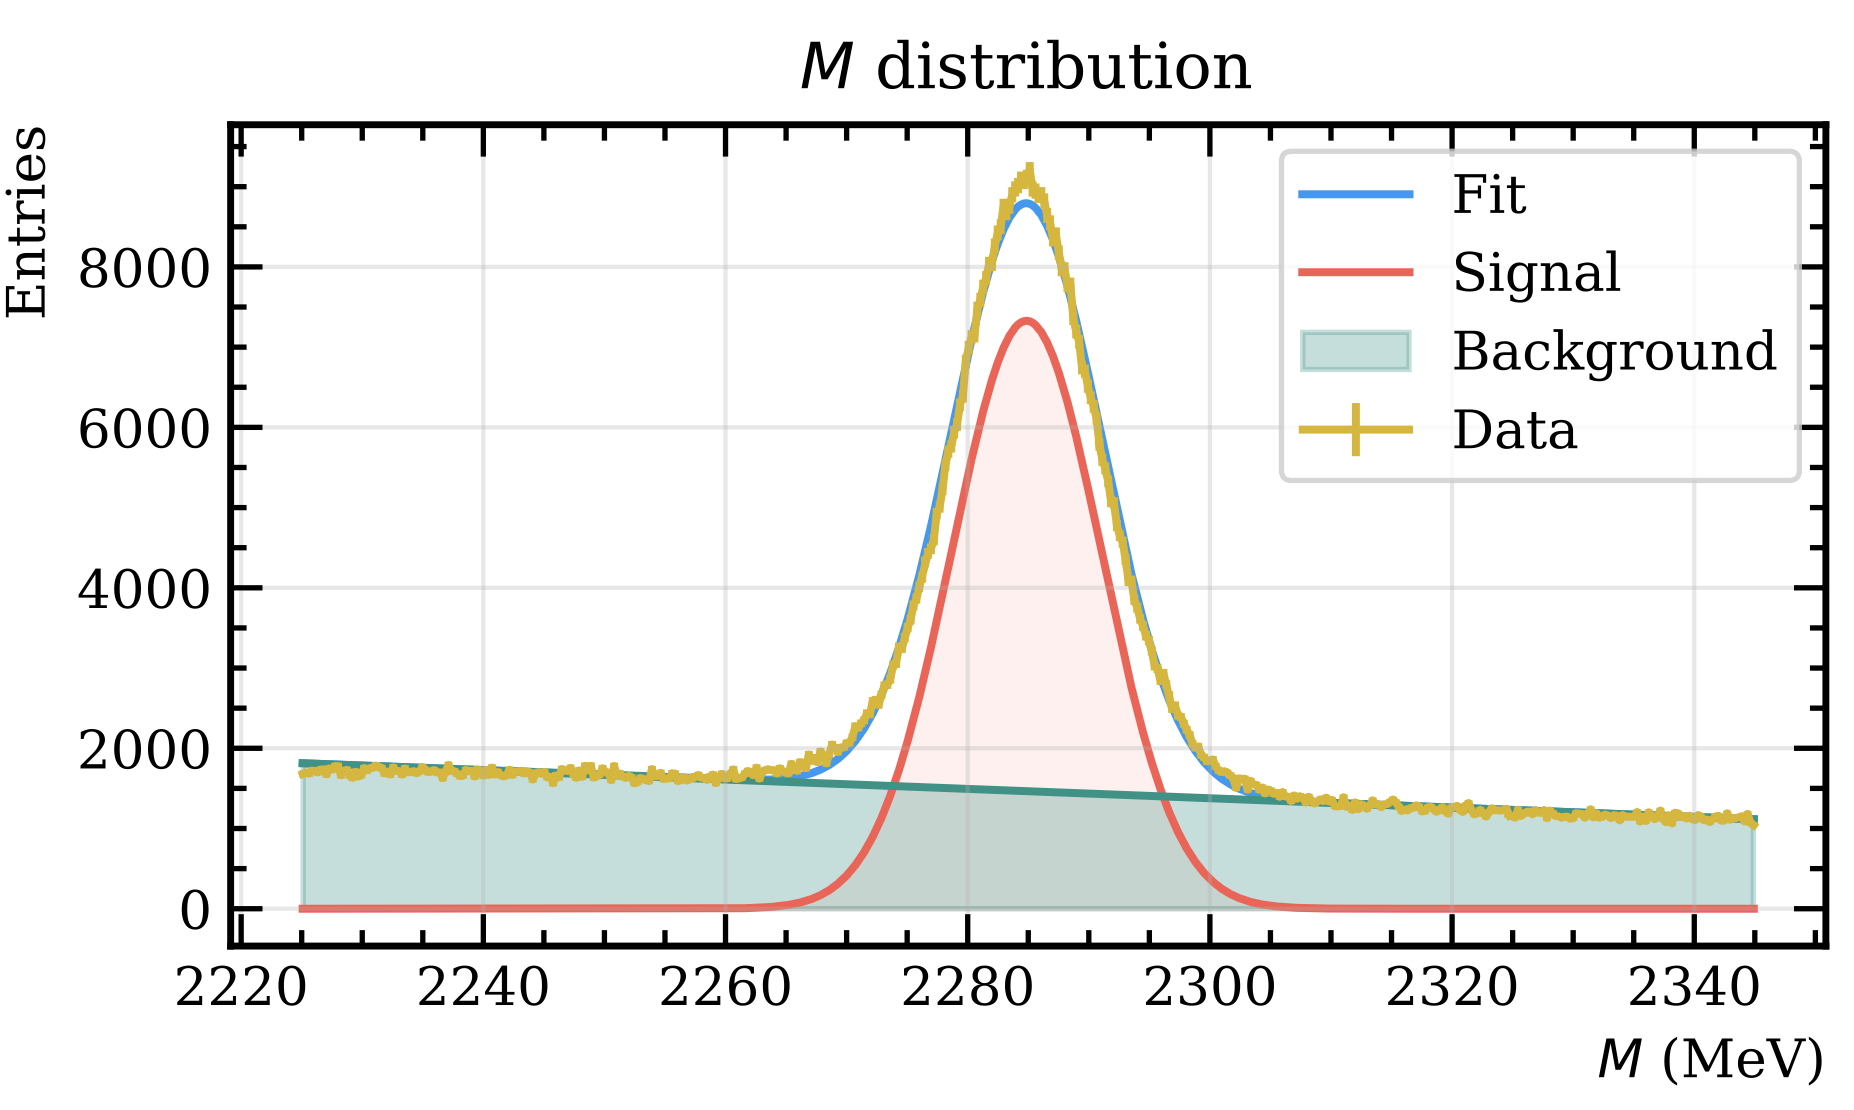

In [8]:
from wand.image import Image as WImage
img = WImage(filename='/data/lhcb/users/mackay/LcTraining/reduced/fits/example_fit.png')
img

### Load in the results of the scan

In [20]:
import numpy as np
import json

def purity(s, b):
    return s / (s+b)

def significance(s, b):
    return s / np.sqrt(s+b)

def eff(y, y_no_cut):
    return y / y_no_cut

results_path = "/data/lhcb/users/mackay/LcTraining/reduced/fits/"

scan_values = np.linspace(0., 0.95, 20)
results = {cut : [] for cut in scan_values}
signal_yield_with_no_cut = 0
bkg_yield_with_no_cut = 0

for cut in scan_values:
    
    with open("{}lc2pkpi_{:.2f}.json".format(results_path, cut)) as f:
        fit_results = json.load(f)
    
    total_yield = fit_results[0][0]
    bkg_fraction = fit_results[0][1]
    
    signal_yield = total_yield * (1-bkg_fraction)
    bkg_yield = total_yield * bkg_fraction
    s
    if cut == 0:
        signal_yield_with_no_cut = signal_yield
        bkg_yield_with_no_cut = bkg_yield
    
    results[cut].append(signal_yield)
    results[cut].append(signal_yield * (147/20))
    results[cut].append(bkg_yield)
    results[cut].append( purity(signal_yield, bkg_yield) )
    results[cut].append( significance(signal_yield, bkg_yield) )
    results[cut].append( eff(signal_yield, signal_yield_with_no_cut) )  
    results[cut].append( 1 - eff(bkg_yield, bkg_yield_with_no_cut) )  

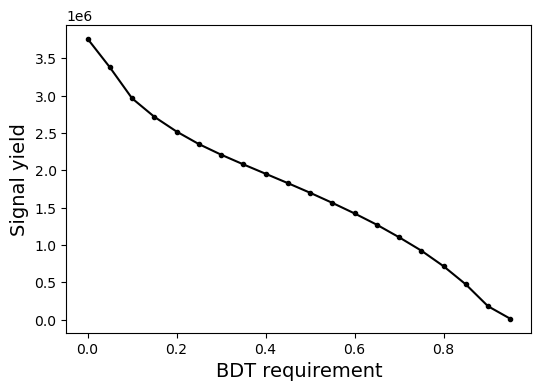

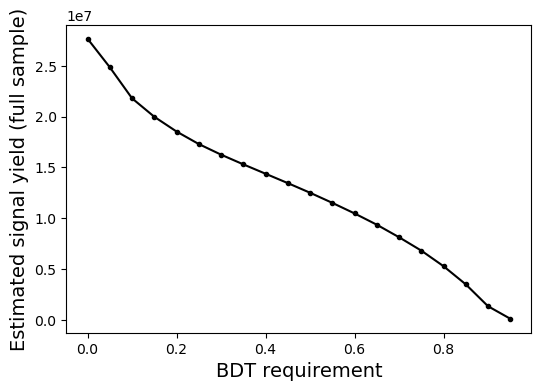

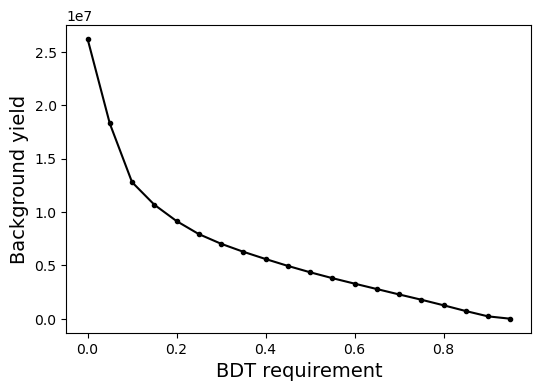

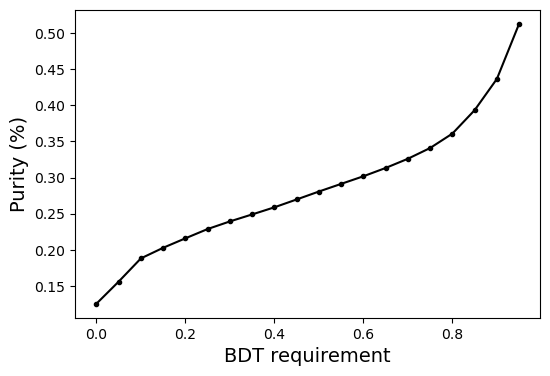

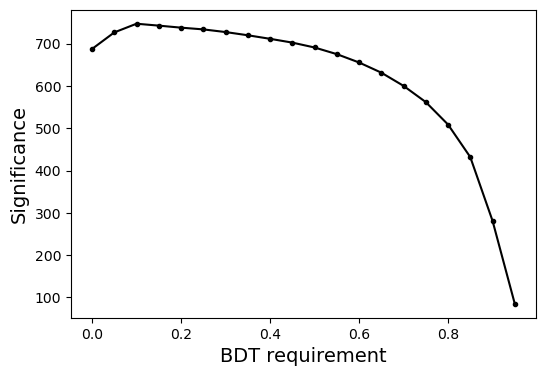

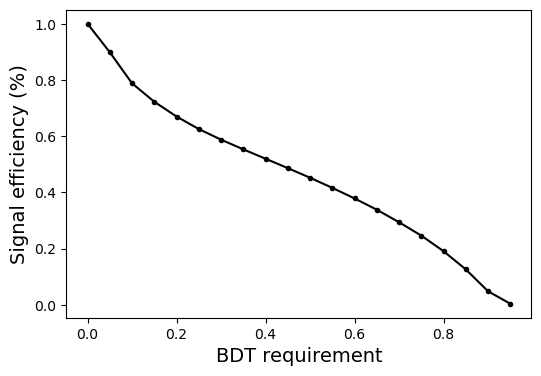

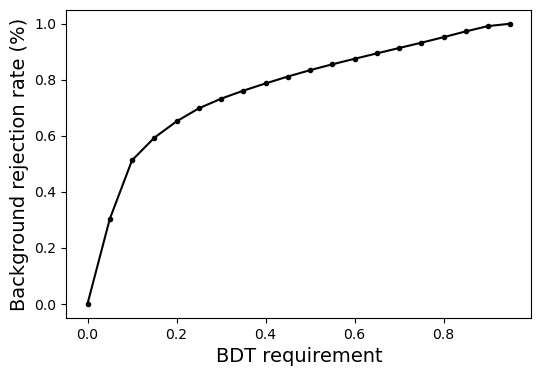

In [24]:
import matplotlib.pyplot as plt

for i, metric in enumerate(["Signal yield", "Estimated signal yield (full sample)", "Background yield", "Purity (%)", "Significance", "Signal efficiency (%)", "Background rejection rate (%)"]):
    
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(
        scan_values,
        [results[cut][i] for cut in scan_values],
        color='k',
        marker='.'
    )
    ax.set_xlabel("BDT requirement", fontsize=14)
    ax.set_ylabel(metric, fontsize=14)